In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!unzip /content/drive/MyDrive/FINAL-DATASET-13-NEW.zip -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52582.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52583.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52586.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52598.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52602.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52603.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52615.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52625.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52630.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52638.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52652.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/image52655.jpg  
 extracting: /content/FINAL-DATASET-13-NEW/train/neutral/imag

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
from torchvision.datasets import ImageFolder

# Define the paths to your preprocessed data folders
train_data_path = '/content/FINAL-DATASET-13-NEW/train'
val_data_path = '/content/FINAL-DATASET-13-NEW/val'
test_data_path = '/content/FINAL-DATASET-13-NEW/test'

# Define the transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create ImageFolder datasets for train, val, and test sets
train_dataset = ImageFolder(train_data_path, transform=transform)
val_dataset = ImageFolder(val_data_path, transform=transform)
test_dataset = ImageFolder(test_data_path, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # Convolutional layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        # Convolutional layer 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        # Convolutional layer 4
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(0.25)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256*16*16, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        # Apply conv follow by batch norm, ReLU activation and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.dropout1(self.bn2(self.conv2(x)))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.dropout2(self.bn4(self.conv4(x)))))

        # Flatten the output for dense layer
        x = x.view(x.size(0), -1)

        # Apply dense layers with batch norm and dropout
        x = F.relu(self.bn5(self.fc1(x)))
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [7]:
# Create the model
model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
import torch

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Optimize further for CUDA (if using NVIDIA GPU)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True

# Adjust the number of epochs based on your experimentation
num_epochs = 20
patience = 5
best_val_loss = float('inf')
counter = 0

# Transfer the model to GPU (if available)
model = model.to(device)

# Make sure to create the optimizer after moving the model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training loop
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        print(f'Training - Batch {batch_idx + 1}/{len(train_loader)}')

        # Transfer data and targets to GPU (if available)
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_loader):
            print(f'Validation - Batch {batch_idx + 1}/{len(val_loader)}')

            # Transfer data and targets to GPU (if available)
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1

        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/mainmodel-latest.pth')


Streaming output truncated to the last 5000 lines.
Training - Batch 438/804
Training - Batch 439/804
Training - Batch 440/804
Training - Batch 441/804
Training - Batch 442/804
Training - Batch 443/804
Training - Batch 444/804
Training - Batch 445/804
Training - Batch 446/804
Training - Batch 447/804
Training - Batch 448/804
Training - Batch 449/804
Training - Batch 450/804
Training - Batch 451/804
Training - Batch 452/804
Training - Batch 453/804
Training - Batch 454/804
Training - Batch 455/804
Training - Batch 456/804
Training - Batch 457/804
Training - Batch 458/804
Training - Batch 459/804
Training - Batch 460/804
Training - Batch 461/804
Training - Batch 462/804
Training - Batch 463/804
Training - Batch 464/804
Training - Batch 465/804
Training - Batch 466/804
Training - Batch 467/804
Training - Batch 468/804
Training - Batch 469/804
Training - Batch 470/804
Training - Batch 471/804
Training - Batch 472/804
Training - Batch 473/804
Training - Batch 474/804
Training - Batch 475/804

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming model is already defined, move it to GPU
model = model.to(device)

# Load labels
train_labels = pd.read_csv('/content/FINAL-DATASET-13-NEW/train/train_labels.csv')
test_labels = pd.read_csv('/content/FINAL-DATASET-13-NEW/test/test_labels.csv')

# Initialize Label Encoder
label_encoder = LabelEncoder()
label_encoder.fit(train_labels['Label'])

# Set the model to evaluation mode
model.eval()
test_loss = 0.0
correct = 0
total = 0
predictions = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
        # Transfer data and targets to GPU
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        # Transfer predictions back to CPU
        predictions.extend(predicted.cpu().numpy())

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate test accuracy
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Transform test labels using the label encoder
test_labels_encoded = label_encoder.transform(test_labels['Label'])

# Generate confusion matrix and classification report
true_labels = test_labels_encoded
confusion = confusion_matrix(true_labels, predictions)
classification_rep = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_rep)

# Set the model back to training mode
model.train()


Test Accuracy: 76.96%
Confusion Matrix:
[[ 605    0    0  306]
 [   1   92  221   10]
 [   2   77 1037   29]
 [  94    0    1  741]]

Classification Report:
              precision    recall  f1-score   support

       anger       0.86      0.66      0.75       911
       bored       0.54      0.28      0.37       324
     engaged       0.82      0.91      0.86      1145
     neutral       0.68      0.89      0.77       836

    accuracy                           0.77      3216
   macro avg       0.73      0.69      0.69      3216
weighted avg       0.77      0.77      0.76      3216



CustomCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

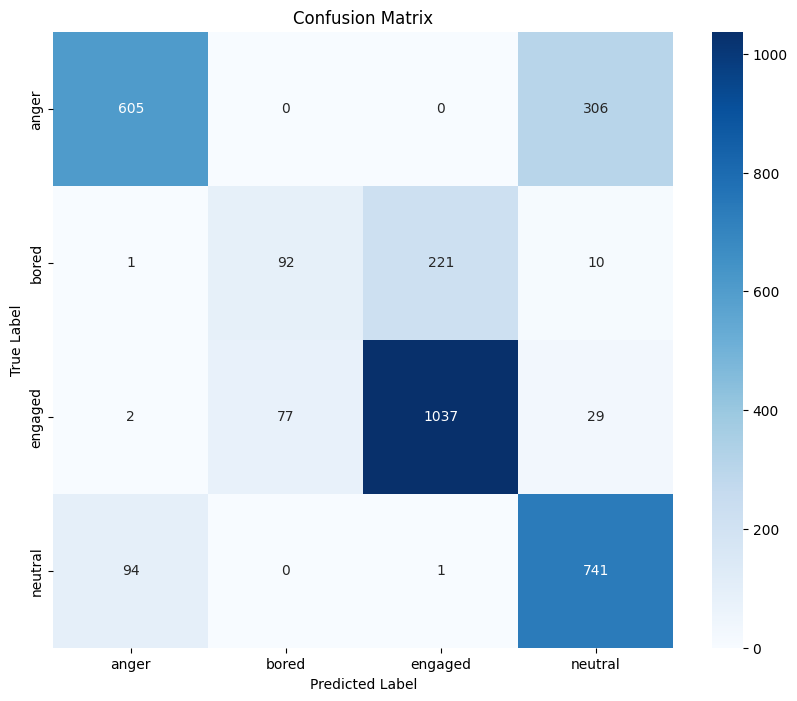

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


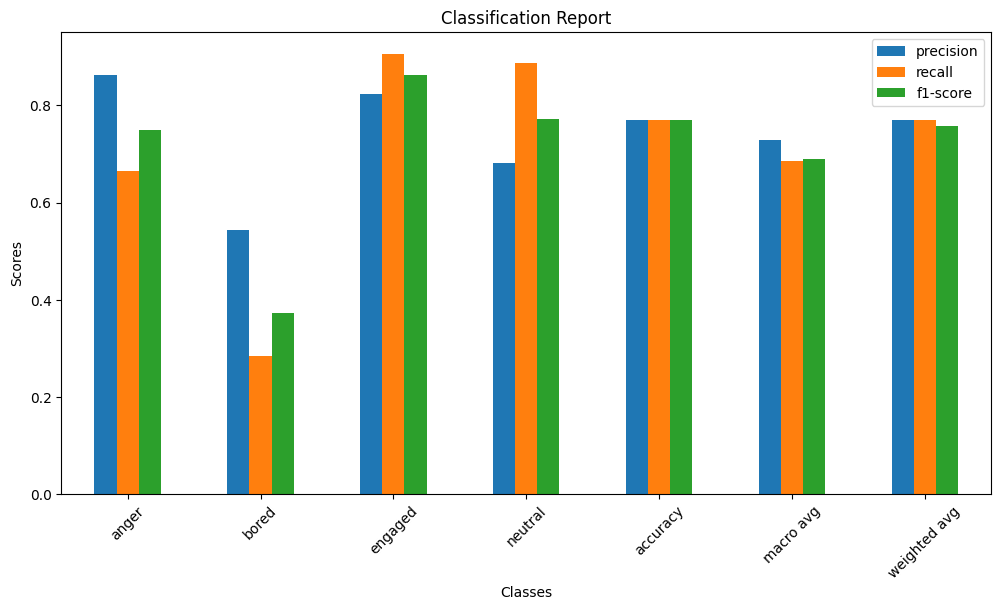

In [11]:
import pandas as pd

# Convert classification report to a DataFrame
report = classification_report(true_labels, predictions, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Drop the 'support' column for the plot
report_df = report_df.drop('support', axis=1)

# Plotting
report_df.plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()


In [12]:
from sklearn.metrics import classification_report

# Generate classification report for individual classes and macro average
report = classification_report(true_labels, predictions, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate micro average metrics
micro_precision = precision_score(true_labels, predictions, average='micro')
micro_recall = recall_score(true_labels, predictions, average='micro')
micro_f1 = f1_score(true_labels, predictions, average='micro')

# Add micro average metrics to the DataFrame
report_df.loc['micro avg'] = [micro_precision, micro_recall, micro_f1, None]


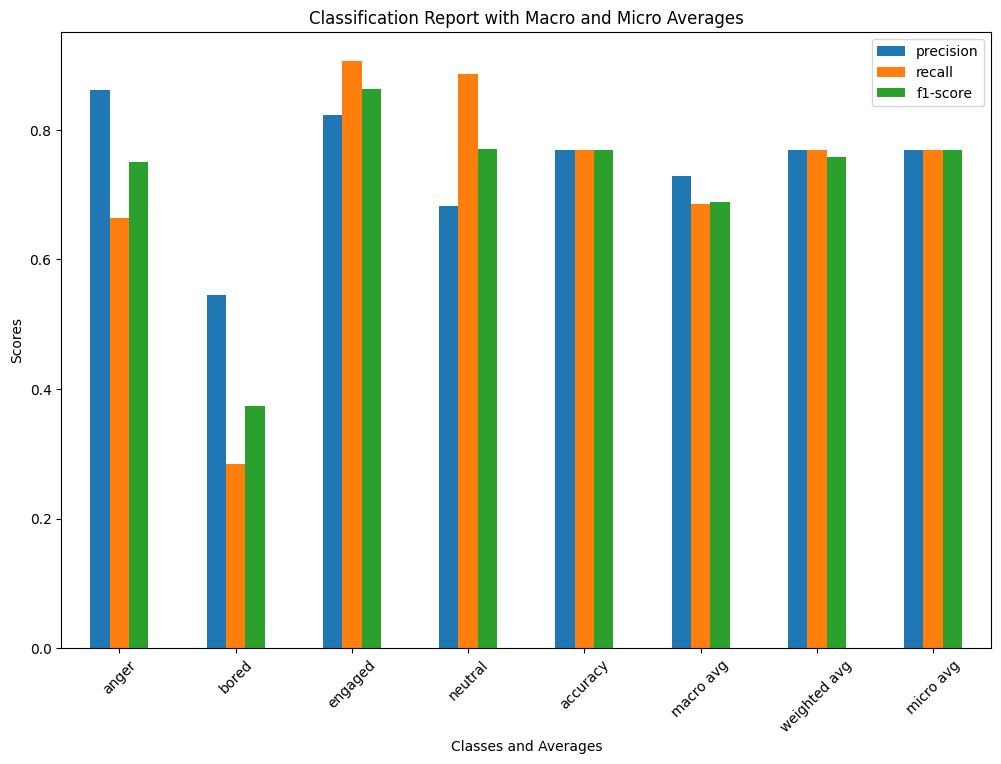

In [14]:
import matplotlib.pyplot as plt

# Drop the 'support' column for the plot and plot the DataFrame
report_df.drop('support', axis=1, inplace=True)
report_df.plot(kind='bar', figsize=(12, 8))
plt.title('Classification Report with Macro and Micro Averages')
plt.xlabel('Classes and Averages')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Micro Average Metrics
micro_precision = precision_score(true_labels, predictions, average='micro')
micro_recall = recall_score(true_labels, predictions, average='micro')
micro_f1 = f1_score(true_labels, predictions, average='micro')

# Calculate Macro Average Metrics
macro_precision = precision_score(true_labels, predictions, average='macro')
macro_recall = recall_score(true_labels, predictions, average='macro')
macro_f1 = f1_score(true_labels, predictions, average='macro')

# Printing the Micro and Macro Averages
print("Micro Average Metrics:")
print(f"Precision: {micro_precision:.2f}")
print(f"Recall: {micro_recall:.2f}")
print(f"F1-Score: {micro_f1:.2f}")

print("\nMacro Average Metrics:")
print(f"Precision: {macro_precision:.2f}")
print(f"Recall: {macro_recall:.2f}")
print(f"F1-Score: {macro_f1:.2f}")


Micro Average Metrics:
Precision: 0.77
Recall: 0.77
F1-Score: 0.77

Macro Average Metrics:
Precision: 0.73
Recall: 0.69
F1-Score: 0.69


blah
